0


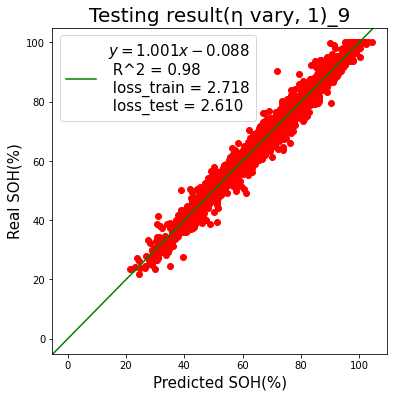

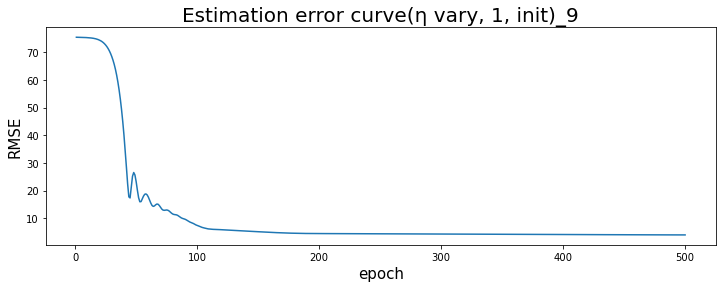

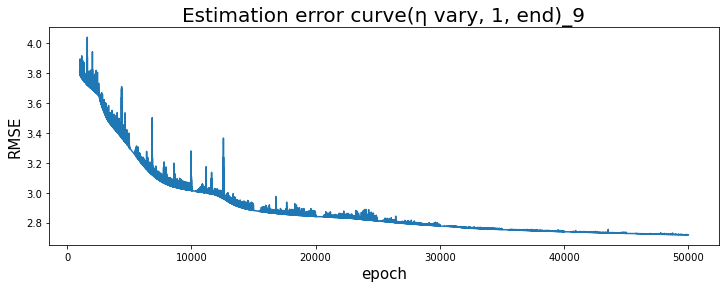

hyperparameters =  Epoch = 50001, hidden_1= 100;; hidden_2= 20;; hidden_3= 5,learning_rate = <torch.optim.lr_scheduler.StepLR object at 0x000001BDA4CF7B48>, lambda_l2 = 0.0002
Result_train =  [2.566044, 2.547542, 2.614023, 2.543983, 2.542731, 2.560132, 2.575873, 2.514125, 2.522626, 2.717534]
2.57
Result_test =  [2.744844, 2.77696, 2.649587, 2.593478, 2.602194, 2.611902, 2.748693, 2.53779, 2.657476, 2.609894]
2.653
total_corr(^2) =  [0.978, 0.977, 0.98, 0.98, 0.979, 0.98, 0.977, 0.98, 0.978, 0.98]
0.979


NameError: name 'factor' is not defined

In [2]:
'''ML_noerror.csv, varying learning rate:更動optimizer出現位置'''
import random
import torch
from torch import nn, optim
import math
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp

D = 5  # dimensions
C = 1  # num_classes
H1 = 100  # num_hidden_units_1
H2 = 20  # num_hidden_units_2
H3 = 5  # num_hidden_units_3

filename = "ML_noerror.csv"     # print(data)
data_r = np.genfromtxt(filename, delimiter = ',', dtype = None, skip_header = 0, encoding = 'UTF-8')     #, usecols = [7,15,37,38,53]
[Row,Column] = data_r.shape     # 確認data(?)...print(data.shape); print(data); print(type(data[1,0]))
scaler = pp.MinMaxScaler().fit(data_r[:,1:6])     # 默認數據壓縮范圍為[0,1]
data_var = scaler.transform(data_r[:,1:6])
data_SOH = data_r[:,0:1]
data = np.hstack((data_SOH, data_var))     # 製作normalized features+未調整SOH數據
# learning_rate = 3e-3
lambda_l2 = 2e-4
n_networks = 1     # Number of networks
criterion = torch.nn.MSELoss()     # nn package also has different loss functions. We use MSE for a regression task
totalerr_train = []; totalerr_test = []; total_corr = [];

for i in range(10):
    train_set = [];
    test_set = [];
    eveloss = [];
    lrlist = []
    models = list()
    y_pretrain = list()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for j in range(len(data)):
        if j%10 == i:
            test_set.append(j)
        else:
            train_set.append(j)
    X = torch.from_numpy(data[train_set,1:6].astype(np.float64))
    y = torch.from_numpy(data[train_set,0:1].astype(np.float64))
    X_test = torch.from_numpy(data[test_set,1:6].astype(np.float64))
    y_test = torch.from_numpy(data[test_set,0:1].astype(np.float64))
    for mod in range(n_networks):
      # nn package to create our linear model     # https://stackoverflow.com/questions/46141690/how-do-i-write-a-pytorch-sequential-model
      # each Linear module has a weight and bias     # https://discuss.pytorch.org/t/mlp-with-one-hidden-layer-dimensions-modules/48841
        model = nn.Sequential(
            nn.Linear(D, H1),
            nn.ReLU(),     # if mod < n_networks // 2 else nn.Tanh(),
            nn.Linear(H1, H2),
            nn.ReLU(),     # if mod < n_networks // 2 else nn.Tanh(),
            nn.Linear(H2, H3),
            nn.ReLU(),     # if mod < n_networks // 2 else nn.Tanh(),
            nn.Linear(H3, C)
        )
        model.to(device)
      # Append models
        models.append(model)
      # we use the optim package to apply ADAM
      # for our parameter updates
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=lambda_l2)     # built-in L2
        learning_rate = optim.lr_scheduler.StepLR(optimizer, 5000, 0.71, last_epoch=-1)
        #learning_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=1000, verbose=False, threshold = 0.0001, threshold_mode = 'rel', cooldown=0, min_lr = 0.0015, eps = 1e-08)
      # e = 1.  # plotting purpose.
      ## Training
        for t in range(1,50001,1):
          # Feed forward to get the logits
            y_pred = model(X.float())
          # Append pre-train output
            if t == 0:
                y_pretrain.append(y_pred.detach())
          # Compute the loss and accuracy
            loss = torch.sqrt(criterion(y_pred.float(), y.float()))
            eveloss.append(np.round(loss.item(),6))
          # we use the optim package to apply ADAM
          # for our parameter updates
            print(f"[Round]: {i+1}, [MODEL]: {mod + 1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}, [lr]: {learning_rate}")
            print(optimizer)
            display.clear_output(wait=True)
          # zero the gradients before running
          # the backward pass.
            optimizer.zero_grad()
          # Backward pass to compute the gradient of loss w.r.t our learnable params. 
            loss.backward()
          # Update params
            optimizer.step()
            learning_rate.step()
            if t == 50000:
                # print(lrlist)
                print(len(lrlist))
                totalerr_train.append(np.round(loss.item(),6))  
              ## Testing
                y_test_pred = model(X_test.float())
              # Compute the loss and accuracy
                loss_test = torch.sqrt(criterion(y_test_pred.float(), y_test.float()))
                y_test_array = []; y_test_pred_array = [];
                for ii in range(len(y_test)):
                    y_test_array.append(y_test.detach().numpy()[ii][0].astype(np.float64))
                    y_test_pred_array.append(y_test_pred.detach().numpy()[ii][0].astype(np.float64))
                R = np.corrcoef(y_test_array, y_test_pred_array)[0,1];     ##[0,1],造成dead kernel
                R_sq = np.round(R*R,3)
                totalerr_test.append(np.round(loss_test.item(),6))
                total_corr.append(np.round(R_sq,3))
                ## 畫圖    ### 試驗浮動學習率時改過'title'名稱,正式訓練時要改回來 ###
                plt.figure(figsize=(6,6))
                plt.plot(y_test_pred_array, y_test_array, 'ro');     #
                m1, b1 = np.polyfit(y_test_pred_array, y_test_array, 1);
                plt.axline(xy1=(0, b1), slope=m1, color='g', label=f'$y = {m1:.3f}x {b1:+.3f}$\n R^2 = {R_sq}\n loss_train = {loss.item():.3f}\n loss_test = {loss_test:.3f}') # 
                plt.xlabel("Predicted SOH(%)", fontsize=15)
                plt.ylabel("Real SOH(%)", fontsize=15)
                plt.title("Testing result(η vary, 1)" + "_" + f"{i}", fontsize=20);
                plt.legend(fontsize=15);
                plt.savefig("Testing result" + "_Round " + f"{i}" + ".jpg"); plt.show();  #save as jpg
                plt.figure(figsize=(12,4))
                plt.plot(np.arange(1,501,1),eveloss[1:501]);     # ,'ro'
                plt.xlabel("epoch", fontsize=15)
                plt.ylabel("RMSE", fontsize=15)
                plt.title("Estimation error curve(η vary, 1, init)" + "_" + f"{i}", fontsize=20);
                plt.savefig("Estimation error curve(η vary, 1, init)" + "_" + f"{i}" + ".jpg"); plt.show();  #save as jpg
                plt.figure(figsize=(12,4))
                plt.plot(np.arange(1001,50000,1),eveloss[1001:]);     # ,'ro'
                plt.xlabel("epoch", fontsize=15)
                plt.ylabel("RMSE", fontsize=15)
                plt.title("Estimation error curve(η vary, 1, end)" + "_" + f"{i}", fontsize=20);
                plt.savefig("Estimation error curve(η vary, 1, end)" + "_" + f"{i}" + ".jpg"); plt.show();''' #save as jpg'''

print("hyperparameters = ", 'Epoch = ' + f"{t+1}" + ',' + ' hidden_1= ' + f"{H1}" + ';;' + ' hidden_2= ' + f"{H2}" + ';;' + ' hidden_3= ' + f"{H3}" + ',' + 'learning_rate = ' + f"{learning_rate}" + ', ' + "lambda_l2 = " + f"{lambda_l2}")
print("Result_train = ", totalerr_train); print(np.round(np.mean(totalerr_train),3))
print("Result_test = ", totalerr_test); print(np.round(np.mean(totalerr_test),3))
print("total_corr(^2) = ", total_corr); print(np.round(np.mean(total_corr),3))
print(" factor="+f"{factor}" + ", patience="+f"{patience}" + ", threshold="+f"{threshold}" + ", cooldown=" + f"{cooldown}" + ", min_lr=" + f"{min_lr}" + ", eps=" + f"{eps}")


In [ ]:
'''Varying learning rate'''
hyperparameters =  Epoch = 50001, hidden_1= 100;; hidden_2= 20;; hidden_3= 5,learning_rate = <torch.optim.lr_scheduler.StepLR object at 0x000001BDA4CF7B48>, lambda_l2 = 0.0002
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=lambda_l2)     # built-in L2
        learning_rate = optim.lr_scheduler.StepLR(optimizer, 5000, 0.71, last_epoch=-1)
Result_train =  [2.566044, 2.547542, 2.614023, 2.543983, 2.542731, 2.560132, 2.575873, 2.514125, 2.522626, 2.717534]
2.57
Result_test =  [2.744844, 2.77696, 2.649587, 2.593478, 2.602194, 2.611902, 2.748693, 2.53779, 2.657476, 2.609894]
2.653
total_corr(^2) =  [0.978, 0.977, 0.98, 0.98, 0.979, 0.98, 0.977, 0.98, 0.978, 0.98]
0.979

hyperparameters =  Epoch = 50001, hidden_1= 100;; hidden_2= 20;; hidden_3= 5,learning_rate = <torch.optim.lr_scheduler.StepLR object at 0x0000022328EDE908>, lambda_l2 = 0.0002
        optimizer = torch.optim.Adam(model.parameters(), lr=0.006, weight_decay=lambda_l2)     # built-in L2
        learning_rate = optim.lr_scheduler.StepLR(optimizer, 15000, 0.5, last_epoch=-1)
Result_train =  [2.681409, 2.573762, 2.574055, 2.574112, 2.617602, 2.666903, 2.566755, 2.57508, 2.55396, 2.646155]
2.603
Result_test =  [2.831492, 2.735675, 2.555834, 2.632293, 2.788496, 2.665818, 2.796215, 2.541344, 2.651163, 2.523012]
2.672
total_corr(^2) =  [0.976, 0.977, 0.981, 0.979, 0.976, 0.979, 0.976, 0.98, 0.979, 0.981]
0.978

hyperparameters =  Epoch = 50001, hidden_1= 100;; hidden_2= 20;; hidden_3= 5,learning_rate = <torch.optim.lr_scheduler.StepLR object at 0x0000022331739748>, lambda_l2 = 0.0002
        optimizer = torch.optim.Adam(model.parameters(), lr=0.004, weight_decay=lambda_l2)     # built-in L2
        learning_rate = optim.lr_scheduler.StepLR(optimizer, 15000, 0.7, last_epoch=-1)
Result_train =  [2.654433, 2.615271, 2.611319, 2.53152, 2.549218, 2.729043, 2.559859, 2.643316, 2.512426, 2.593752]
2.6
Result_test =  [2.817439, 2.714229, 2.560593, 2.562847, 2.672007, 2.678493, 2.756917, 2.605738, 2.627271, 2.501563]
2.65
total_corr(^2) =  [0.977, 0.978, 0.981, 0.981, 0.979, 0.979, 0.977, 0.979, 0.979, 0.981]
0.979

hyperparameters =  Epoch = 50000, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x0000011F26C8B8C8>, lambda_l2 = 0.0002
        optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=lambda_l2)     # built-in L2
        learning_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=1000, verbose=False, threshold = 0.0001, threshold_mode = 'rel', cooldown=0, min_lr = 0.0015, eps = 1e-08)
Result_train =  [2.77868, 2.85078, 2.856443, 2.844933, 2.738397, 3.338714, 2.845046, 2.80606, 2.788599, 2.861664]
2.871
Result_test =  [2.863003, 3.054167, 2.848538, 2.920161, 2.755866, 3.311253, 3.023754, 2.695084, 2.927215, 2.750605]
2.915
total_corr(^2) =  [0.976, 0.972, 0.976, 0.975, 0.977, 0.968, 0.972, 0.977, 0.974, 0.977]
0.974

hyperparameters =  Epoch = 50000, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.StepLR object at 0x0000011F26668048>, lambda_l2 = 0.0002
        optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=lambda_l2)     # built-in L2
        (factor=0.9, patience=10, threshold = 0.0001, cooldown=0, min_lr = 0, eps = 1e-08) 
Result_train =  [2.837299, 2.870091, 2.907262, 2.824723, 2.755105, 2.827763, 3.069979, 2.839217, 2.931465, 2.898482]
2.876
Result_test =  [2.923345, 3.022469, 2.860121, 2.921994, 2.75, 2.764423, 3.252997, 2.695289, 2.99969, 2.791808]
2.898
total_corr(^2) =  [0.975, 0.973, 0.977, 0.975, 0.978, 0.978, 0.968, 0.978, 0.973, 0.977]
0.975

hyperparameters =  Epoch = 1000, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.StepLR object at 0x0000011F25D7CBC8>, lambda_l2 = 0.0002
Result_train =  [3.732166]
3.732
Result_test =  [3.820002]
3.82
total_corr(^2) =  [0.957]
0.957

hyperparameters =  Epoch = 50000, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.StepLR object at 0x0000011F26BD6288>, lambda_l2 = 0.0002
Result_train =  [2.785157]
2.785
Result_test =  [2.873468]
2.873
total_corr(^2) =  [0.976]
0.976

hyperparameters =  Epoch = 100000, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.StepLR object at 0x0000011F2576AE08>, lambda_l2 = 0.0005
Result_train =  [2.703141, 2.763812, 2.701534, 2.806793, 2.874842, 2.738375, 2.75616, 2.739286, 2.756703, 2.896114]
2.774
Result_test =  [2.821369, 3.016169, 2.649674, 2.93666, 2.899716, 2.737226, 2.93607, 2.651659, 2.809938, 2.801461]
2.826
total_corr(^2) =  [0.976, 0.972, 0.98, 0.974, 0.974, 0.978, 0.974, 0.978, 0.976, 0.976]
0.976

hyperparameters =  Epoch = 100000, hidden_1= 50;; hidden_2= 5,learning_rate = <torch.optim.lr_scheduler.StepLR object at 0x0000011F262EF8C8>, lambda_l2 = 0.0005
Result_train =  [4.593644]
4.594
Result_test =  [4.708463]
4.708
total_corr(^2) =  [0.934]
0.934

In [ ]:
# # # # # # # # # # # # # # # Varying learning rate;Varying learning rate # # # # # # # # # # # # # # #
[Round]: 1, [MODEL]: 1, [EPOCH]: 34370, [LOSS]: 4.367013, [lr]: 2.776178285534146e-06
[Round]: 1, [MODEL]: 1, [EPOCH]: 31253, [LOSS]: 4.375611, [lr]: 2.876247577398448e-06

if t < 60:
    learning_rate = lrlist[-1]*math.pow(eveloss[-1]/eveloss[-2], np.log(t))
elif 59 < t < 200:
    learning_rate = 0.003
elif (t%800) == 0:
    learning_rate = lrlist[-1]*math.pow(800+math.pow(t,0.8), 0.4)
else:
    learning_rate = lrlist[-1]*math.pow(eveloss[-1]/eveloss[-20], 2)

if t < 60:
    learning_rate = lrlist[-1]*math.pow(eveloss[-1]/eveloss[-2], np.log(t))
elif 59 < t < 200:
    learning_rate = 0.003
elif (t%800) == 0:
    learning_rate = lrlist[-1]*math.pow(800+math.pow(t,0.8), 0.4)
else:
    learning_rate = lrlist[-1]*math.pow(eveloss[-1]/eveloss[-20], 2)

In [147]:
import numpy as np

a = random.random()*2
aa = np.round(a,4)
print(aa)

1.5173


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                 8.934e+04
Date:                Sun, 25 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:27:16   Log-Likelihood:                -73149.
No. Observations:               25547   AIC:                         1.463e+05
Df Residuals:                   25541   BIC:                         1.464e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -85.4791      1.896    -45.089      0.0

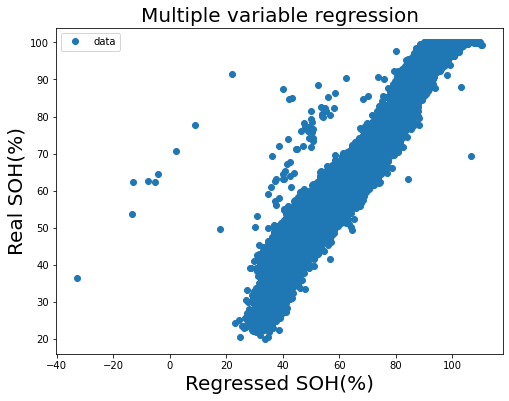

In [19]:
'''多變數線性迴歸'''
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import preprocessing as pp
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

filename = "ML_noerror.csv"     # print(data)
data = np.genfromtxt(filename, delimiter = ',', dtype = None, skip_header = 0, encoding = 'UTF-8')     #, usecols = [7,15,37,38,53]
[Row,Column] = data.shape     # 確認data(?)...print(data.shape); print(data); print(type(data[1,0]))
scaler = pp.MinMaxScaler().fit(data[:,1:6])
data_var = scaler.transform(data[:,1:6])     # 歸一化,默認數據壓縮范圍為[0,1]
features = sm.add_constant(data_var)
SOH = data[:,0:1]
'''print("features\n", features)'''
# print("SOH\n", torch.from_numpy(SOH.astype(np.float64)))
model = sm.OLS(SOH,features)
result = model.fit()     # 模型擬合'''
print(result.summary())     # 模型描述 '''

SOH_fitted = result.fittedvalues
# print("SOH_fitted\n", torch.from_numpy(SOH_fitted.astype(np.float64)))
error = SOH_fitted-SOH.T
error_2 = error*error
print("RMSE\n", np.sqrt(sum(error_2[0])/25547))
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(SOH_fitted, SOH, 'o', label='data')
plt.xlabel("Regressed SOH(%)", fontsize=20)
plt.ylabel("Real SOH(%)", fontsize=20)
plt.title("Multiple variable regression", fontsize=20);
# ax.plot(features, y_fitted, 'r--.', label='OLS')
ax.legend(loc='best');
